In [ ]:
# Download and unzip the dataset
!wget --content-disposition https://s3.unistra.fr/camma_public/github/convlstm_tracker/data.zip
!unzip data.zip

--2024-06-25 13:48:11--  https://s3.unistra.fr/camma_public/github/convlstm_tracker/data.zip
Resolving s3.unistra.fr (s3.unistra.fr)... 130.79.200.152
Connecting to s3.unistra.fr (s3.unistra.fr)|130.79.200.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14883257 (14M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  14.19M  9.55MB/s    in 1.5s    

2024-06-25 13:48:13 (9.55 MB/s) - ‘data.zip’ saved [14883257/14883257]

Archive:  data.zip
   creating: data/
 extracting: data/README.md          
  inflating: data/surgical_video.avi  


In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling2D, Flatten, Dense, TimeDistributed, Conv2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc

In [ ]:
import json
from tqdm import tqdm
import argparse
import requests
import hashlib
import tarfile
import os
import requests
from tqdm import tqdm
import hashlib
import tarfile

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# Hardcoded arguments for now
data_rootdir = "your_data_root_directory"
verify_checksum = True
keep_archive = False

url = "https://s3.unistra.fr/camma_public/datasets/cholec80/cholec80.tar.gz"
chunk_size = 2 ** 20

outfile = os.path.join(data_rootdir, "cholec80.tar.gz")
outdir = os.path.join(data_rootdir, "cholec80")

In [ ]:
#Hardcoded arguments
data_rootdir = "/content"
verify_checksum = True
keep_archive = False

URL = "https://s3.unistra.fr/camma_public/datasets/cholec80/cholec80.tar.gz"
outfile = os.path.join(data_rootdir, "cholec80.tar.gz")
outdir = os.path.join(data_rootdir, "cholec80")

# Download
print("Downloading archive to {}".format(outfile))
r = requests.get(URL, stream=True)




In [ ]:

# Cleanup
if not keep_archive:
    os.remove(outfile)

# Config setup
config = {
    "cholec80_dir": outdir
}

with open("config.json", "w") as f:
    json.dump(config, f, indent=2)

print("All done - config saved to {}".format(os.path.join(os.getcwd(), "config.json")))

All done - config saved to /content/config.json


In [ ]:
# Define paths
data_path = 'data/surgical_video.avi'
ckpt_path = 'ckpt'

# Constants
img_height = 480
img_width = 854
img_channel = 3
num_classes = 7

In [ ]:
# Function to load frames from video
def load_frames_from_video(video_path, img_height, img_width):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_width, img_height))
        frames.append(frame)
    cap.release()
    return frames

In [ ]:
# Load frames from video
frames = load_frames_from_video(data_path, img_height, img_width)
labels = np.zeros(len(frames))  # Placeholder for labels, adjust as needed

In [ ]:
# Apply different filters to frames
def apply_filters(frames):
    filtered_frames = []
    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sharp = cv2.filter2D(gray, -1, np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]]))
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
        canny = cv2.Canny(gray, 100, 200)
        roberts = cv2.filter2D(gray, -1, np.array([[1, 0], [0, -1]]))
        prewitt = cv2.filter2D(gray, -1, np.array([[1, 1, 1], [1, -7, 1], [1, 1, 1]]))
        filtered_frames.append([sharp, sobel, canny, roberts, prewitt])
    return np.array(filtered_frames)

filtered_frames = apply_filters(frames)


In [ ]:
# Split the dataset for cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)


In [ ]:
# Function to build models
def build_model(base_model):
    model = Sequential()
    model.add(TimeDistributed(base_model, input_shape=(None, img_height, img_width, img_channel)))
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True))
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [ ]:
# Placeholder for evaluation metrics
all_precision, all_recall, all_accuracy, all_roc_auc = [], [], [], []

for fold_num, (train_index, val_index) in enumerate(kf.split(filtered_frames)):
    X_train, X_val = filtered_frames[train_index], filtered_frames[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    # Build and compile VGG16 LSTM model
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))
    vgg16_lstm_model = build_model(vgg16_base)
    vgg16_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the VGG16 LSTM model
    vgg16_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the VGG16 LSTM model
    y_pred = vgg16_lstm_model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    precision = precision_score(y_true_classes, y_pred_classes, average='macro')
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    fpr, tpr, _ = roc_curve(y_true_classes, y_pred_classes, pos_label=1)
    roc_auc = auc(fpr, tpr)

    all_precision.append(precision)
    all_recall.append(recall)
    all_accuracy.append(accuracy)
    all_roc_auc.append(roc_auc)

    print(f"Fold: {fold_num+1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}, AUC: {roc_auc}")

# Print overall metrics
print(f"Overall Precision: {np.mean(all_precision)}, Overall Recall: {np.mean(all_recall)}, Overall Accuracy: {np.mean(all_accuracy)}, Overall AUC: {np.mean(all_roc_auc)}")


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from google.colab import drive

In [ ]:
# Define parameters
img_height = 480
img_width = 854
img_channel = 3
num_classes = 7

In [ ]:
# Function to load frames from a given video directory
def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return np.array(frames)

# Function to load annotations
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip header line
            values = line.strip().split('\t')
            if len(values) != 8:
                continue  # Skip malformed lines
            tools_present = [int(val) for val in values[1:]]  # Skip the frame number
            annotations.append(tools_present)
    return np.array(annotations)

# Load and preprocess data
def load_and_preprocess(video_dirs, annotation_files, img_height, img_width):
    all_frames = []
    all_labels = []
    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            all_frames.append(frames)
            all_labels.append(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")
    return np.array(all_frames), np.array(all_labels)

In [ ]:
# Paths to video frame directories and annotation files
video_dirs = [f"/content/data/frames/video{i:02d}" for i in range(1, 81)]
annotation_files = [f"/content/data/tool_annotations/video{i:02d}-tool.txt" for i in [11, 22, 32, 43, 53, 66, 74, 77]]

In [ ]:
video_dirs

['/content/data/frames/video01',
 '/content/data/frames/video02',
 '/content/data/frames/video03',
 '/content/data/frames/video04',
 '/content/data/frames/video05',
 '/content/data/frames/video06',
 '/content/data/frames/video07',
 '/content/data/frames/video08',
 '/content/data/frames/video09',
 '/content/data/frames/video10',
 '/content/data/frames/video11',
 '/content/data/frames/video12',
 '/content/data/frames/video13',
 '/content/data/frames/video14',
 '/content/data/frames/video15',
 '/content/data/frames/video16',
 '/content/data/frames/video17',
 '/content/data/frames/video18',
 '/content/data/frames/video19',
 '/content/data/frames/video20',
 '/content/data/frames/video21',
 '/content/data/frames/video22',
 '/content/data/frames/video23',
 '/content/data/frames/video24',
 '/content/data/frames/video25',
 '/content/data/frames/video26',
 '/content/data/frames/video27',
 '/content/data/frames/video28',
 '/content/data/frames/video29',
 '/content/data/frames/video30',
 '/content

In [ ]:
annotation_files

['/content/data/tool_annotations/video11-tool.txt',
 '/content/data/tool_annotations/video22-tool.txt',
 '/content/data/tool_annotations/video32-tool.txt',
 '/content/data/tool_annotations/video43-tool.txt',
 '/content/data/tool_annotations/video53-tool.txt',
 '/content/data/tool_annotations/video66-tool.txt',
 '/content/data/tool_annotations/video74-tool.txt',
 '/content/data/tool_annotations/video77-tool.txt']

In [ ]:
def load_and_preprocess(video_dirs, annotation_files, img_height, img_width):
    all_frames = []
    all_labels = []
    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            all_frames.append(frames)
            all_labels.append(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")
    return np.array(all_frames), np.array(all_labels)


In [ ]:
print(f"Total videos processed: {len(video_dirs)}")
print(f"Total frames loaded: {len(frames)}, Total labels loaded: {len(labels)}")


Total videos processed: 80
Total frames loaded: 0, Total labels loaded: 0


In [ ]:
video_dirs = [f"/content/data/frames/video{i:02d}" for i in range(1, 81)]


In [ ]:
tool_annotation_files = [f"/content/data/tool_annotations/{i:02d}-tool.txt" for i in [11, 22, 32, 43, 53, 66, 74, 77]]
phase_annotation_files = [f"/content/data/phase_annotations/{i:02d}-phase.txt" for i in range(11, 29)] + [f"/content/data/phase_annotations/{i:02d}-phase.txt" for i in range(56, 57)]

all_annotation_files = tool_annotation_files + [f for f in phase_annotation_files if os.path.exists(f)]


In [ ]:
all_annotation_files

['/content/data/tool_annotations/11-tool.txt',
 '/content/data/tool_annotations/22-tool.txt',
 '/content/data/tool_annotations/32-tool.txt',
 '/content/data/tool_annotations/43-tool.txt',
 '/content/data/tool_annotations/53-tool.txt',
 '/content/data/tool_annotations/66-tool.txt',
 '/content/data/tool_annotations/74-tool.txt',
 '/content/data/tool_annotations/77-tool.txt']

In [ ]:
if len(frames) != len(labels):
  print(f"Warning: Mismatch between total frames ({len(frames)}) and total labels ({len(labels)}).")


In [ ]:

# Function to load frames from a given video directory
def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return np.array(frames)

In [ ]:
# Function to load annotations
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip header line
            values = line.strip().split('\t')
            tools_present = [int(val) for val in values[1:]]  # Skip the frame number
            annotations.append(tools_present)
    return np.array(annotations)

In [ ]:
# Load and preprocess data
def load_and_preprocess(video_dirs, all_annotation_files, img_height, img_width):
    all_frames = []
    all_labels = []
    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            all_frames.append(frames)
            all_labels.append(labels)
        else:
            print(f"Warning: Mismatch between frames and labels in {video_dir}")
    return np.array(all_frames), np.array(all_labels)

In [ ]:
def load_annotations(all_annotation_files):
  annotations = []
  with open(annotation_file, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:  # Skip header line
      values = line.strip().split('\t')
      tools_present = [int(val) for val in values[1:]]# Skip the frame number
      annotations.append(tools_present)
  return np.array(annotations)

In [ ]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(frames, labels, test_size=0.2, random_state=42)

# Build the VGG-16 LSTM model
def build_vgg16_lstm_model():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))
    model = Sequential()
    model.add(TimeDistributed(vgg16_base, input_shape=(None, img_height, img_width, img_channel)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Build the ResNet-50 LSTM model
def build_resnet50_lstm_model():
    resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))
    model = Sequential()
    model.add(TimeDistributed(resnet50_base, input_shape=(None, img_height, img_width, img_channel)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Initialize models
vgg16_lstm_model = build_vgg16_lstm_model()
resnet50_lstm_model = build_resnet50_lstm_model()

# Compile models
vgg16_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Perform K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
data = list(zip(X_train, y_train))

# Placeholder for evaluation metrics
all_precision, all_recall, all_accuracy, all_roc_auc = [], [], [], []

for fold_num, (train_index, val_index) in enumerate(kf.split(data)):
    print(f'Fold {fold_num + 1}')
    train_data = [data[i] for i in train_index]
    val_data = [data[i] for i in val_index]

    train_frames_fold, train_labels_fold = zip(*train_data)
    val_frames_fold, val_labels_fold = zip(*val_data)

    # Train the VGG-16 LSTM model
    vgg16_lstm_model.fit(np.array(train_frames_fold), np.array(train_labels_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_labels_fold)))

    # Train the ResNet-50 LSTM model
    resnet50_lstm_model.fit(np.array(train_frames_fold), np.array(train_labels_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_labels_fold)))

    # Evaluate the models
    for model, model_name in zip([vgg16_lstm_model, resnet50_lstm_model], ['VGG16 LSTM', 'ResNet50 LSTM']):
        y_pred = model.predict(np.array(val_frames_fold))
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(np.array(val_labels_fold), axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='macro')
        recall = recall_score(y_true_classes, y_pred_classes, average='macro')
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        fpr, tpr, _ = roc_curve(y_true_classes.ravel(), y_pred.ravel(), pos_label=1)
        roc_auc = auc(fpr, tpr)

        all_precision.append(precision)
        all_recall.append(recall)
        all_accuracy.append(accuracy)
        all_roc_auc.append(roc_auc)

        print(f"{model_name} - Fold: {fold_num+1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}, AUC: {roc_auc}")

# Print overall metrics
print(f"Overall Precision: {np.mean(all_precision)}, Overall Recall: {np.mean(all_recall)}, Overall Accuracy: {np.mean(all_accuracy)}, Overall AUC: {np.mean(all_roc_auc)}")


In [ ]:
# Function to load frames from a given video directory
def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.png'):  # Adjusted to handle .png files
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return np.array(frames)

# Function to load annotations
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip header line
            values = line.strip().split('\t')
            if len(values) != 8:
                continue  # Skip malformed lines
            tools_present = [int(val) for val in values[1:]]  # Skip the frame number
            annotations.append(tools_present)
    return np.array(annotations)

In [ ]:

# Load and preprocess data
def load_and_preprocess(video_dirs, annotation_files, img_height, img_width):
    all_frames = []
    all_labels = []
    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            all_frames.append(frames)
            all_labels.append(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")
    return np.array(all_frames), np.array(all_labels)


In [ ]:
# Paths to video frame directories and annotation files
video_dirs = [f"/content/data/frames/video{i:02d}" for i in range(1, 81)]
annotation_files = [f"/content/data/tool_annotations/video{i:02d}-tool.txt" for i in [11, 22, 32, 43, 53, 66, 74, 77]]

In [ ]:
import os
import cv2
import numpy as np

In [ ]:
def load_frames_and_labels(data_dir, img_height, img_width):
    video_dirs = sorted([os.path.join(data_dir, f'video{i:02d}') for i in range(1, 81)])
    annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-phase.txt') for i in [11, 12, 13, 28, 29, 40, 55, 56]])
    tool_annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-tool.txt') for i in [11, 22, 32, 43, 53, 66, 74, 77]])

    all_frames = []
    all_labels = []

    for video_dir, annotation_file, tool_annotation_file in zip(video_dirs, annotation_files, tool_annotation_files):
        frames = []
        labels = []

        # Load annotations (assuming phase annotations here)
        with open(annotation_file, 'r') as file:
            annotations = file.readlines()

        # Load tool annotations
        with open(tool_annotation_file, 'r') as file:
            tool_annotations = file.readlines()

        # Load frames
        for filename in sorted(os.listdir(video_dir)):
            if filename.endswith('.png'):
                img_path = os.path.join(video_dir, filename)
                frame = cv2.imread(img_path)
                frame = cv2.resize(frame, (img_width, img_height))
                frames.append(frame)

                # Extract label from annotations based on filename or index
                frame_idx = int(filename.split('_')[-1].split('.')[0])
                label = annotations[frame_idx].strip()
                labels.append(label)

        all_frames.append(frames)
        all_labels.append(labels)

    return np.array(all_frames), np.array(all_labels)


In [ ]:
import os
import cv2
import numpy as np

def load_frames_and_labels(data_dir, img_height, img_width):
    video_dirs = sorted([os.path.join(data_dir, f'video{i:02d}') for i in range(1, 81)])
    annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-phase.txt') for i in [11, 12, 13, 28, 29, 40, 55, 56]])
    tool_annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-tool.txt') for i in [11, 22, 32, 43, 53, 66, 74, 77]])

    all_frames = []
    all_labels = []

    for video_dir, annotation_file, tool_annotation_file in zip(video_dirs, annotation_files, tool_annotation_files):
        frames = []
        labels = []

        # Load annotations (phase annotations)
        with open(annotation_file, 'r') as file:
            annotations = file.readlines()

        # Load tool annotations
        with open(tool_annotation_file, 'r') as file:
            tool_annotations = file.readlines()

        # Load frames
        for filename in sorted(os.listdir(video_dir)):
            if filename.endswith('.png'):
                img_path = os.path.join(video_dir, filename)
                frame = cv2.imread(img_path)
                frame = cv2.resize(frame, (img_width, img_height))
                frames.append(frame)

                # Extract label from phase annotations based on filename index
                frame_idx = int(filename.split('_')[-1].split('.')[0])
                label = annotations[frame_idx].strip()
                labels.append(label)

        # Check if frames and labels are consistent and not empty
        if len(frames) == len(labels) and len(frames) > 0:
            all_frames.append(frames)
            all_labels.append(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")

    return np.array(all_frames), np.array(all_labels)


In [ ]:
# Define parameters
img_height = 480
img_width = 854
img_channel = 3
num_classes = 7

In [ ]:
# Function to load frames from a given video directory
def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.png'):  # Ensure it's a PNG file
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return np.array(frames)


In [ ]:
# Function to load annotations
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip header line
            values = line.strip().split('\t')
            if len(values) != 8:
                continue  # Skip malformed lines
            tools_present = [int(val) for val in values[1:]]  # Skip the frame number
            annotations.append(tools_present)
    return np.array(annotations)

In [ ]:
# Function to load frames and labels
def load_frames_and_labels(data_dir, img_height, img_width):
    video_dirs = sorted([os.path.join(data_dir, f'video{i:02d}') for i in range(1, 81)])
    annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-phase.txt') for i in [11, 12, 13, 28, 29, 40, 55, 56]])
    tool_annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-tool.txt') for i in [11, 22, 32, 43, 53, 66, 74, 77]])

    all_frames = []
    all_labels = []

    for video_dir, annotation_file, tool_annotation_file in zip(video_dirs, annotation_files, tool_annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            all_frames.append(frames)
            all_labels.append(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")

    return np.array(all_frames), np.array(all_labels)

In [ ]:
# Load and preprocess the dataset
data_dir = '/content/data/frames'
frames, labels = load_frames_and_labels(data_dir, img_height, img_width)

# Filter out empty arrays due to mismatch warnings
frames = [f for f in frames if f.size > 0]
labels = [l for l in labels if l.size > 0]

# Convert lists to numpy arrays
frames = np.array(frames)
labels = np.array(labels)

# Reshape frames and labels for model input
#frames = frames.reshape(-1, frames.shape[1] // 5, img_height, img_width, img_channel)  # Assuming 5 frames per sequence
#labels = labels.reshape(-1, labels.shape[1] // 5, num_classes)  # Assuming 5 frames per sequence

# Convert labels to categorical
labels = np.array([to_categorical(label, num_classes=num_classes) for label in labels])

In [ ]:
# Build the VGG-16 LSTM model
def build_vgg16_lstm_model():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))
    model = Sequential()
    model.add(TimeDistributed(vgg16_base, input_shape=(None, img_height, img_width, img_channel)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Build the ResNet-50 LSTM model
def build_resnet50_lstm_model():
    resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))
    model = Sequential()
    model.add(TimeDistributed(resnet50_base, input_shape=(None, img_height, img_width, img_channel)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Initialize models
vgg16_lstm_model = build_vgg16_lstm_model()
resnet50_lstm_model = build_resnet50_lstm_model()

# Compile models
vgg16_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Perform K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
data = list(zip(X_train, y_train))

# Placeholder for evaluation metrics
all_precision, all_recall, all_accuracy, all_roc_auc = [], [], [], []

for fold_num, (train_index, val_index) in enumerate(kf.split(data)):
    print(f'Fold {fold_num + 1}')
    train_data = [data[i] for i in train_index]
    val_data = [data[i] for i in val_index]

    train_frames_fold, train_labels_fold = zip(*train_data)
    val_frames_fold, val_labels_fold = zip(*val_data)

    # Train the VGG-16 LSTM model
    vgg16_lstm_model.fit(np.array(train_frames_fold), np.array(train_labels_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_labels_fold)))

    # Train the ResNet-50 LSTM model
    resnet50_lstm_model.fit(np.array(train_frames_fold), np.array(train_labels_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_labels_fold)))

    # Evaluate the models
    for model, model_name in zip([vgg16_lstm_model, resnet50_lstm_model], ['VGG16 LSTM', 'ResNet50 LSTM']):
        y_pred = model.predict(np.array(val_frames_fold))
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(np.array(val_labels_fold), axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='macro')
        recall = recall_score(y_true_classes, y_pred_classes, average='macro')
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        fpr, tpr, _ = roc_curve(y_true_classes.ravel(), y_pred.ravel(), pos_label=1)
        roc_auc = auc(fpr, tpr)

        all_precision.append(precision)
        all_recall.append(recall)
        all_accuracy.append(accuracy)
        all_roc_auc.append(roc_auc)

        print(f"{model_name} - Fold: {fold_num+1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}, AUC: {roc_auc}")

# Print overall metrics
print(f"Overall Precision: {np.mean(all_precision)}, Overall Recall: {np.mean(all_recall)}, Overall Accuracy: {np.mean(all_accuracy)}, Overall AUC: {np.mean(all_roc_auc)}")


In [ ]:

def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.png'):  # Ensure it's a PNG file
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return frames


In [ ]:
def load_annotations(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip header line
            values = line.strip().split('\t')
            if len(values) != 8:
                continue  # Skip malformed lines
            tools_present = [int(val) for val in values[1:]]  # Skip the frame number
            annotations.append(tools_present)
    return np.array(annotations)

In [ ]:
def load_and_preprocess(video_dirs, annotation_files, img_height, img_width):
    all_frames = []
    all_labels = []
    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            all_frames.extend(frames)
            all_labels.extend(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")
    return np.array(all_frames), np.array(all_labels)

In [ ]:

video_dirs = [f"/content/data/frames/video{i:02d}" for i in range(1, 81)]
annotation_files = [f"/content/data/frames/video{i:02d}-tool.txt" for i in [11, 22, 32, 43, 53, 66, 74, 77]]

frames, labels = load_and_preprocess(video_dirs, annotation_files, img_height, img_width)

In [ ]:
# Filter out empty arrays due to mismatch warnings
frames = [f for f in frames if f.size > 0]
labels = [l for l in labels if l.size > 0]

# Check if any valid data remains after filtering
if len(frames) == 0 or len(labels) == 0:
    raise ValueError("No valid frames or labels after filtering.")

# Convert lists to numpy arrays
frames = np.array(frames)
labels = np.array(labels)

# Reshape frames and labels for model input
frames = frames.reshape(-1, 5, img_height, img_width, img_channel)  # Assuming 5 frames per sequence
labels = labels.reshape(-1, 5, num_classes)  # Assuming 5 frames per sequence

# Convert labels to categorical
labels = np.array([to_categorical(label, num_classes=num_classes) for label in labels])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(frames, labels, test_size=0.2, random_state=42)

# Check if the split has enough data
if len(X_train) == 0 or len(X_val) == 0:
    raise ValueError("Insufficient data to create train-test split with the specified test_size.")

In [ ]:
def build_vgg16_lstm_model():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(5, img_height, img_width, img_channel))
    model = Sequential()
    model.add(TimeDistributed(vgg16_base))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
def build_resnet50_lstm_model():
    resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(5, img_height, img_width, img_channel))
    model = Sequential()
    model.add(TimeDistributed(resnet50_base))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
vgg16_lstm_model = build_vgg16_lstm_model()
resnet50_lstm_model = build_resnet50_lstm_model()

vgg16_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

kf = KFold(n_splits=3, shuffle=True, random_state=42)
data = list(zip(X_train, y_train))

all_precision, all_recall, all_accuracy, all_roc_auc = [], [], [], []

for fold_num, (train_index, val_index) in enumerate(kf.split(data)):
    print(f'Fold {fold_num + 1}')
    train_data = [data[i] for i in train_index]
    val_data = [data[i] for i in val_index]

    train_frames_fold, train_labels_fold = zip(*train_data)
    val_frames_fold, val_labels_fold = zip(*val_data)

    vgg16_lstm_model.fit(np.array(train_frames_fold), np.array(train_labels_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_labels_fold)))

    resnet50_lstm_model.fit(np.array(train_frames_fold), np.array(train_labels_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_labels_fold)))

    for model, model_name in zip([vgg16_lstm_model, resnet50_lstm_model], ['VGG16 LSTM', 'ResNet50 LSTM']):
        y_pred = model.predict(np.array(val_frames_fold))
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(np.array(val_labels_fold), axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='macro')
        recall = recall_score(y_true_classes, y_pred_classes, average='macro')
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        fpr, tpr, _ = roc_curve(y_true_classes.ravel(), y_pred.ravel(), pos_label=1)
        roc_auc = auc(fpr, tpr)

        all_precision.append(precision)
        all_recall.append(recall)
        all_accuracy.append(accuracy)
        all_roc_auc.append(roc_auc)

        print(f"{model_name} - Fold: {fold_num+1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}, AUC: {roc_auc}")

print(f"Overall Precision: {np.mean(all_precision)}, Overall Recall: {np.mean(all_recall)}, Overall Accuracy: {np.mean(all_accuracy)}, Overall AUC: {np.mean(all_roc_auc)}")


In [ ]:
def load_frames_and_labels(data_dir, img_height, img_width):
    video_dirs = sorted([os.path.join(data_dir, f'video{i:02d}') for i in range(1, 81)])
    annotation_files = sorted([os.path.join(data_dir, f'video{i:02d}-tool.txt') for i in range(1, 81)])  # Adjust file name pattern if needed

    all_frames = []
    all_labels = []

    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = []
        labels = []

        # Load annotations (assuming tool annotations here)
        with open(annotation_file, 'r') as file:
            annotations = file.readlines()

        # Load frames
        for filename in sorted(os.listdir(video_dir)):
            if filename.endswith('.png'):
                img_path = os.path.join(video_dir, filename)
                frame = cv2.imread(img_path)
                frame = cv2.resize(frame, (img_width, img_height))
                frames.append(frame)

                # Extract label from annotations based on filename or index
                frame_idx = int(filename.split('_')[-1].split('.')[0])
                label = annotations[frame_idx].strip()
                labels.append(label)

        all_frames.append(frames)
        all_labels.append(labels)

    return np.array(all_frames), np.array(all_labels)

In [ ]:
def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.png'):  # Ensure it's a PNG file
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return np.array(frames)

In [ ]:
def load_phase_annotations(phase_file):
    with open(phase_file, 'r') as file:
        phases = file.readlines()
    phases = [phase.strip() for phase in phases]
    return np.array(phases)

In [ ]:
def load_tool_annotations(tool_file):
    with open(tool_file, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines[1:]:  # Skipping header line assuming the first line is header
        values = line.strip().split('\t')
        annotations.append([int(val) for val in values[1:]])  # Skip the frame number, convert to int
    return np.array(annotations)

In [ ]:
def load_frames_phase_and_annotations(data_dir, img_height, img_width):
    video_dirs = sorted([os.path.join(data_dir, f'video{i:02d}') for i in range(1, 81)])
    phase_files = sorted([os.path.join(data_dir, f'video{i:02d}-phase.txt') for i in [11, 12, 13, 28, 29, 40, 55, 56]])
    tool_files = sorted([os.path.join(data_dir, f'video{i:02d}-tool.txt') for i in [11, 22, 32, 43, 53, 66, 74, 77]])

    all_frames = []
    all_phases = []
    all_annotations = []

    for video_dir, phase_file, tool_file in zip(video_dirs, phase_files, tool_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        phases = load_phase_annotations(phase_file)
        annotations = load_tool_annotations(tool_file)

        if len(frames) == len(phases) and len(frames) == len(annotations):
            all_frames.append(frames)
            all_phases.append(phases)
            all_annotations.append(annotations)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}), phases ({len(phases)}), and annotations ({len(annotations)}) in {video_dir}")

    return np.array(all_frames), np.array(all_phases), np.array(all_annotations)


In [ ]:
# Define data directory and parameters
data_dir = '/content/data/frames'
img_height = 480
img_width = 854
img_channel = 3
num_classes = 7

In [ ]:
def load_frames_from_directory(directory, img_height, img_width):
    frames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.png'):  # Ensure it's a PNG file
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    return np.array(frames)

def load_phase_annotations(phase_file):
    with open(phase_file, 'r') as file:
        phases = file.readlines()
    phases = [phase.strip() for phase in phases]
    return np.array(phases)

def load_tool_annotations(tool_file):
    with open(tool_file, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines[1:]:  # Skipping header line assuming the first line is header
        values = line.strip().split('\t')
        annotations.append([int(val) for val in values[1:]])  # Skip the frame number, convert to int
    return np.array(annotations)

def load_frames_phase_and_annotations(data_dir, img_height, img_width):
    video_dirs = sorted([os.path.join(data_dir, f'video{i:02d}') for i in range(1, 81)])
    phase_files = sorted([os.path.join(data_dir, f'video{i:02d}-phase.txt') for i in [11, 12, 13, 28, 29, 40, 55, 56]])
    tool_files = sorted([os.path.join(data_dir, f'video{i:02d}-tool.txt') for i in [11, 22, 32, 43, 53, 66, 74, 77]])

    all_frames = []
    all_phases = []
    all_annotations = []

    for video_dir, phase_file, tool_file in zip(video_dirs, phase_files, tool_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        phases = load_phase_annotations(phase_file)
        annotations = load_tool_annotations(tool_file)

        if len(frames) == len(phases) and len(frames) == len(annotations):
            all_frames.append(frames)
            all_phases.append(phases)
            all_annotations.append(annotations)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}), phases ({len(phases)}), and annotations ({len(annotations)}) in {video_dir}")

    return np.array(all_frames), np.array(all_phases), np.array(all_annotations)

In [ ]:
# Load frames, phases, and annotations
frames, phases, annotations = load_frames_phase_and_annotations(data_dir, img_height, img_width)

# Ensure frames, phases, and annotations are non-empty
frames = [f for f in frames if len(f) > 0]
phases = [p for p in phases if len(p) > 0]
annotations = [a for a in annotations if len(a) > 0]

# Convert lists to numpy arrays
frames = np.array(frames)
phases = np.array(phases)
annotations = np.array(annotations)
# Convert annotations to categorical
annotations = np.array([to_categorical(annotation, num_classes=num_classes) for annotation in annotations])


In [ ]:
# Function to apply filters to frames
def apply_filters(frames):
    filtered_frames = []
    for frame in frames:
        sharp = cv2.filter2D(frame, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
        sobel = cv2.Sobel(frame, cv2.CV_64F, 1, 1, ksize=5)
        canny = cv2.Canny(frame, 100, 200)
        roberts = roberts_filter(frame)
        prewitt = prewitt_filter(frame)
        filtered_frames.append([sharp, sobel, canny, roberts, prewitt])
    return np.array(filtered_frames)

# Roberts cross operator filter
def roberts_filter(image):
    roberts_cross_v = np.array([[1, 0], [0, -1]])
    roberts_cross_h = np.array([[0, 1], [-1, 0]])
    vertical = cv2.filter2D(image, -1, roberts_cross_v)
    horizontal = cv2.filter2D(image, -1, roberts_cross_h)
    return vertical + horizontal

# Prewitt operator filter
def prewitt_filter(image):
    kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    img_prewittx = cv2.filter2D(image, -1, kernelx)
    img_prewitty = cv2.filter2D(image, -1, kernely)
    return img_prewittx + img_prewitty

# Load and preprocess data
def load_and_preprocess(video_dirs, annotation_files, img_height, img_width):
    all_frames = []
    all_labels = []
    for video_dir, annotation_file in zip(video_dirs, annotation_files):
        frames = load_frames_from_directory(video_dir, img_height, img_width)
        labels = load_annotations(annotation_file)
        if len(frames) == len(labels):
            frames = apply_filters(frames)  # Apply filters here
            all_frames.extend(frames)
            all_labels.extend(labels)
        else:
            print(f"Warning: Mismatch between frames ({len(frames)}) and labels ({len(labels)}) in {video_dir}")
    return np.array(all_frames), np.array(all_labels)

# Paths to video frame directories and annotation files
video_dirs = [f"/content/data/frames/video{i:02d}" for i in range(1, 81)]
annotation_files = [f"/content/data/tool_annotations/video{i:02d}-tool.txt" for i in [11, 22, 32, 43, 53, 66, 74, 77]]

# Load and preprocess the dataset
frames, labels = load_and_preprocess(video_dirs, annotation_files, img_height, img_width)

# Filter out empty arrays due to mismatch warnings
frames = frames[frames.any(axis=(1, 2, 3))]
labels = labels[labels.any(axis=1)]

# Check if any valid data remains
if not frames.size or not labels.size:
    raise ValueError("No valid frames or labels after filtering.")

# Convert lists to numpy arrays
frames = np.array(frames)
labels = np.array(labels)

# Reshape frames and labels for model input
frames = frames.reshape(-1, 5, img_height, img_width, img_channel)
labels = labels.reshape(-1, 5, num_classes)

# Convert labels to categorical
labels = np.array([to_categorical(label, num_classes=num_classes) for label in labels])


In [ ]:
# Extract features using CNN
X_train_features = cnn_model.predict(X_train)
X_test_features = cnn_model.predict(X_test)

19/19 [==============================] - 2s 98ms/step


In [ ]:
# Reshape data for LSTM
timesteps = 1  # Treat the flattened feature vector as a single timestep
feature_size = X_train_features.shape[1]

In [ ]:
X_train_lstm = X_train_features.reshape((X_train_features.shape[0], timesteps, feature_size))
X_test_lstm = X_test_features.reshape((X_test_features.shape[0], timesteps, feature_size))

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, feature_size)))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
60/60 [==============================] - 50s 788ms/step - loss: 0.7027 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5167
Epoch 2/10
60/60 [==============================] - 65s 1s/step - loss: 0.6932 - accuracy: 0.4927 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 3/10
60/60 [==============================] - 43s 720ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 4/10
60/60 [==============================] - 43s 723ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6935 - val_accuracy: 0.4833
Epoch 5/10
60/60 [==============================] - 45s 750ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6935 - val_accuracy: 0.4833
Epoch 6/10
60/60 [==============================] - 48s 797ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6936 - val_accuracy: 0.4833
Epoch 7/10
60/60 [==============================] - 46s 764ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6936 - val_accuracy: 0.4833
Ep

In [ ]:
# Evaluate model
y_pred = model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

19/19 [==============================] - 2s 63ms/step


375/375 [==============================] - 1s 1ms/step
Epoch 1/10
1200/1200 [==============================] - 9s 6ms/step - loss: 0.4562 - accuracy: 0.8420 - val_loss: 0.3732 - val_accuracy: 0.8618
Epoch 2/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.3273 - accuracy: 0.8833 - val_loss: 0.3637 - val_accuracy: 0.8656
Epoch 3/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2895 - accuracy: 0.8979 - val_loss: 0.3162 - val_accuracy: 0.8831
Epoch 4/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2627 - accuracy: 0.9060 - val_loss: 0.3217 - val_accuracy: 0.8836
Epoch 5/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2403 - accuracy: 0.9137 - val_loss: 0.3161 - val_accuracy: 0.8842
Epoch 6/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2273 - accuracy: 0.9190 - val_loss: 0.3007 - val_accuracy: 0.8927
Epoch 7/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.217

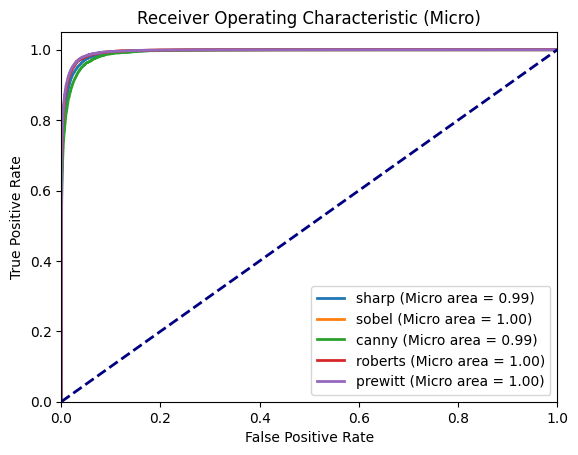

In [ ]:
# Apply different filters
def apply_filters(images, filter_type):
    filtered_images = []
    for img in images:
        img = img_as_float(img)
        if filter_type == 'sharp':
            kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
            filtered_img = convolve(img, kernel)
        elif filter_type == 'sobel':
            filtered_img = sobel(img)
        elif filter_type == 'canny':
            filtered_img = canny(img)
        elif filter_type == 'roberts':
            filtered_img = roberts(img)
        elif filter_type == 'prewitt':
            filtered_img = prewitt(img)
        else:
            raise ValueError("Unknown filter type")
        filtered_images.append(filtered_img)
    return np.array(filtered_images)


# Initialize VGG-16 and ResNet-50 base models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))

# Build LSTM models with VGG-16 and ResNet-50 base models
vgg16_lstm_model = build_lstm_model(vgg16_base)
resnet50_lstm_model = build_lstm_model(resnet50_base)

# Compile models
vgg16_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Perform K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
data = list(zip(X_train, y_train))

all_precision, all_recall, all_accuracy, all_auc = [], [], [], []

for fold_num, (train_index, val_index) in enumerate(kf.split(data)):
    print(f'Fold {fold_num + 1}')
    train_data = [data[i] for i in train_index]
    val_data = [data[i] for i in val_index]

    train_frames_fold, train_annotations_fold = zip(*train_data)
    val_frames_fold, val_annotations_fold = zip(*val_data)

    # Train VGG-16 LSTM model
    vgg16_lstm_model.fit(np.array(train_frames_fold), np.array(train_annotations_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_annotations_fold)))

    # Train ResNet-50 LSTM model
    resnet50_lstm_model.fit(np.array(train_frames_fold), np.array(train_annotations_fold), epochs=10, batch_size=32, validation_data=(np.array(val_frames_fold), np.array(val_annotations_fold)))

    # Evaluate models
    for model, model_name in zip([vgg16_lstm_model, resnet50_lstm_model], ['VGG16 LSTM', 'ResNet50 LSTM']):
        y_pred = model.predict(np.array(val_frames_fold))
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(np.array(val_annotations_fold), axis=1)

        precision = precision_score(y_true_classes, y_pred_classes, average='macro')
        recall = recall_score(y_true_classes, y_pred_classes, average='macro')
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        fpr, tpr, _ = roc_curve(y_true_classes.ravel(), y_pred.ravel(), pos_label=1)
        roc_auc = auc(fpr, tpr)

        all_precision.append(precision)
        all_recall.append(recall)
        all_accuracy.append(accuracy)
        all_auc.append(roc_auc)

# Evaluate model for multiclass classification
def evaluate_model(model, X_test_lstm, y_test):
    y_pred = model.predict(X_test_lstm)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    accuracy = accuracy_score(y_true, y_pred_classes)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return precision, recall, accuracy, fpr, tpr, roc_auc

# Apply filters to real dataset images
filters_to_compare = ['sharp', 'sobel', 'canny', 'roberts', 'prewitt']
results = {}

for filter_type in filters_to_compare:
    # Apply filter to train and test images
    X_train_filtered = apply_filters(X_train, filter_type)
    X_test_filtered = apply_filters(X_test, filter_type)

    # Prepare data
    X_train_processed, X_test_processed, y_train_processed, y_test_processed = prepare_data(X_train_filtered, y_train)

    # Extract features using CNN
    cnn_model = build_cnn_model((X_train_processed.shape[1], X_train_processed.shape[2], 1))
    X_train_features = cnn_model.predict(X_train_processed)
    X_test_features = cnn_model.predict(X_test_processed)

    # Reshape data for LSTM
    timesteps = 1  # Treat the flattened feature vector as a single timestep
    feature_size = X_train_features.shape[1]
    X_train_lstm = X_train_features.reshape((X_train_features.shape[0], timesteps, feature_size))
    X_test_lstm = X_test_features.reshape((X_test_features.shape[0], timesteps, feature_size))

    # Build and train LSTM model
    lstm_model = build_lstm_model((timesteps, feature_size))
    lstm_model.fit(X_train_lstm, y_train_processed, epochs=10, batch_size=32, validation_split=0.2)

    # Evaluate model
    precision, recall, accuracy, fpr, tpr, roc_auc = evaluate_model(lstm_model, X_test_lstm, y_test_processed)
    results[filter_type] = (precision, recall, accuracy, fpr, tpr, roc_auc)

    print(f"Filter: {filter_type}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC (Micro): {roc_auc['micro']}")
    print("\n")

# Plot ROC curves
plt.figure()
for filter_type in filters_to_compare:
    fpr, tpr, roc_auc = results[filter_type][3:]
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'{filter_type} (Micro area = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Micro)')
plt.legend(loc="lower right")
plt.show()


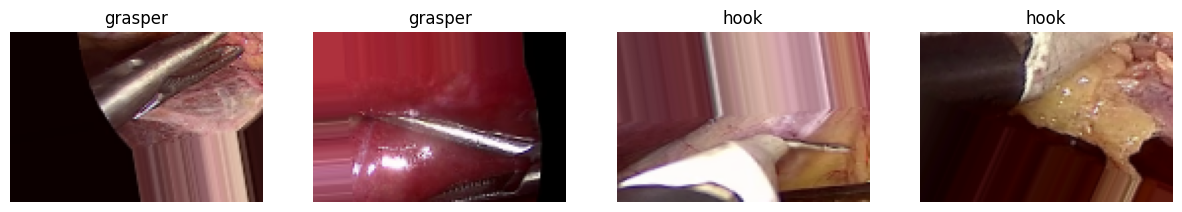

In [ ]:
# Define the figure using a matplotlib.pyplot function
fig, axes = plt.subplots(1,4, figsize=(15, 15))
random_batch =  random.randint(0, len(train_set)-1)
random_images, random_labels = train_set[random_batch]

# For loops are used to iterate over a sequence, in this case each
# image being plotted
for image_number, axs in enumerate(axes):
    img = random_images[image_number]
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(CLASS_NAMES[np.argmax(random_labels[image_number])])

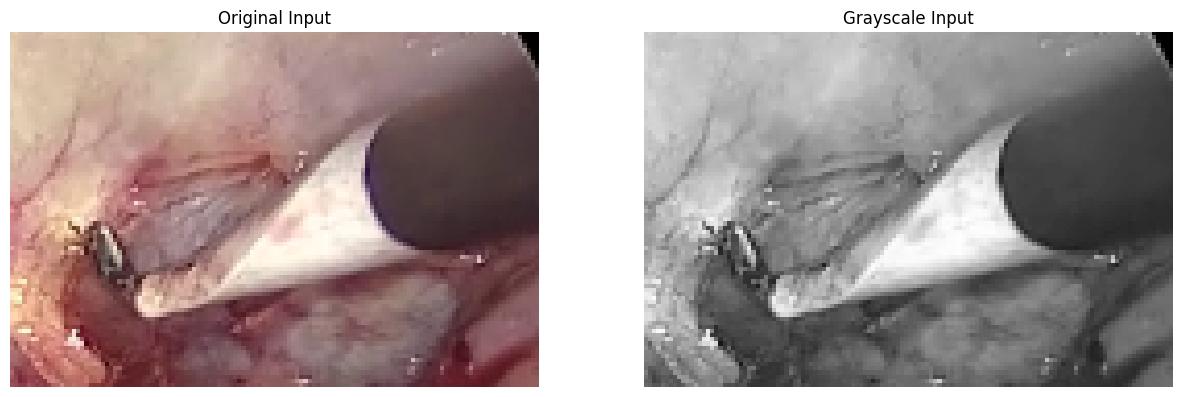

In [ ]:
# Read a sample image
img = plt.imread(path + "/train/hook/7013_16226.png")

# Convert the image to grayscale
img_gray = tf.image.rgb_to_grayscale(img)

# Visualize result
fig = plt.figure(figsize=(15,5))

# Display the original input and it's grayscale version
fig.add_subplot(1, 2, 1); plt.imshow(img);
plt.title("Original Input"); plt.axis("off")

fig.add_subplot(1, 2, 2); plt.imshow(img_gray.numpy()[..., 0], 'gray');
plt.title("Grayscale Input"); plt.axis("off")
plt.show()

In [ ]:
# Constants
TRAINING_SET_SIZE = 1200
VALIDATION_SET_SIZE = 200
TEST_SET_SIZE = 599
CLASS_NAMES = ['grasper', 'hook', 'scissor', 'clipper']
NUMBER_CLASSES = 4
IMAGE_SIZE = (86, 128)
CHANNELS = 3
BATCH_SIZE = 16

In [ ]:


# ImageDataGenerator for training and validation sets
train_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=45,
    width_shift_range=0.3, height_shift_range=0.3,
    horizontal_flip=True, shear_range=0.3,
    zoom_range=0.3, vertical_flip=True
)
train_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/train',
    image_data_generator=train_preprocessing,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    classes=CLASS_NAMES,
    shuffle=True,
)

validation_test_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255
)
validation_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/validation',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

test_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/test',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.


In [ ]:
# Define additional edge detection filters
def apply_filters(img):
    filters = {
        'sobel': cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5) + cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5),
        'canny': cv2.Canny(img, 100, 200),
        'roberts': cv2.filter2D(img, -1, np.array([[1, 0], [0, -1]])) + cv2.filter2D(img, -1, np.array([[0, 1], [-1, 0]])),
        'prewitt': cv2.filter2D(img, -1, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])) + cv2.filter2D(img, -1, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]))
    }
    return filters

# Neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (5, 5), activation="relu", input_shape=(86, 128, 3)),
    tf.keras.layers.MaxPooling2D((5, 5)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(NUMBER_CLASSES, activation="softmax")
])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 22, 32)        4640      
                                                                 
 flatten_1 (Flatten)         (None, 9856)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              40374272  
                                                                 
 dense_4 (Dense)             (None, 2048)              8390656   
                                                      

In [ ]:
# Evaluate on the test set
evaluation = model.evaluate(test_set)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")


38/38 [==============================] - 1s 17ms/step - loss: 0.8313 - accuracy: 0.6845
Test Loss: 0.8312881588935852
Test Accuracy: 0.6844741106033325


Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_15 (Flatten)        (None, 9856)              0         
                                                                 
 dense_45 (Dense)            (None, 4096)              40374272  
                                                             

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


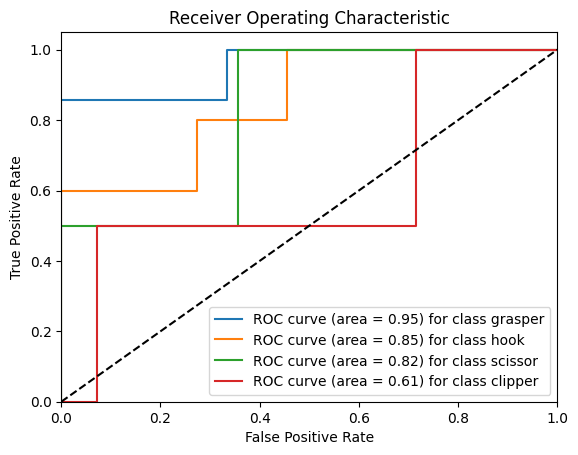

In [ ]:
# ImageDataGenerator for training and validation sets
train_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=45,
    width_shift_range=0.3, height_shift_range=0.3,
    horizontal_flip=True, shear_range=0.3,
    zoom_range=0.3, vertical_flip=True
)
train_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/train',
    image_data_generator=train_preprocessing,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    classes=CLASS_NAMES,
    shuffle=True,
)

validation_test_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255
)
validation_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/validation',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

test_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/test',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

# Define additional edge detection filters
def apply_filters(img):
    filters = {
        'sobel': cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5) + cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5),
        'canny': cv2.Canny(img, 100, 200),
        'roberts': cv2.filter2D(img, -1, np.array([[1, 0], [0, -1]])) + cv2.filter2D(img, -1, np.array([[0, 1], [-1, 0]])),
        'prewitt': cv2.filter2D(img, -1, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])) + cv2.filter2D(img, -1, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]))
    }
    return filters

# Neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (5, 5), activation="relu", input_shape=(86, 128, 3)),
    tf.keras.layers.MaxPooling2D((5, 5)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(NUMBER_CLASSES, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
history = model.fit(train_set, validation_data=validation_set, epochs=15)

# Evaluate on the test set
evaluation = model.evaluate(test_set)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Predicting on the test set
test_images, test_labels = next(test_set)
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Compute Precision, Recall, and Accuracy
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

# Compute ROC curve and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUMBER_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(NUMBER_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {CLASS_NAMES[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.
Training and evaluating model for filter: original
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_16 (Flatten)        (None, 9856)              0         
                                                                 
 dense_48 (Dense)            (None, 4096)              40374272  
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


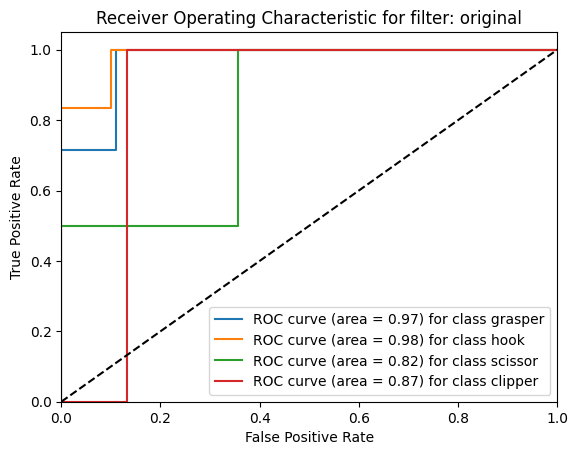

Training and evaluating model for filter: sobel
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_17 (Flatten)        (None, 9856)              0         
                                                                 
 dense_51 (Dense)            (None, 4096)              40374272  
                                                                 
 dense_52 (Dense)            (None, 2048)              8390656   
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


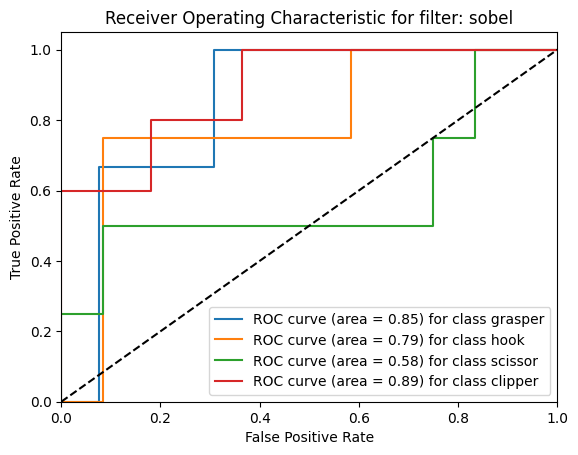

Training and evaluating model for filter: canny
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_18 (Flatten)        (None, 9856)              0         
                                                                 
 dense_54 (Dense)            (None, 4096)              40374272  
                                                                 
 dense_55 (Dense)            (None, 2048)              8390656   
     

Test Loss: 0.8316939473152161
Test Accuracy: 0.7095158696174622
1/1 [==============================] - 0s 75ms/step
Precision: 0.7803571428571427
Recall: 0.6875
Accuracy: 0.6875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


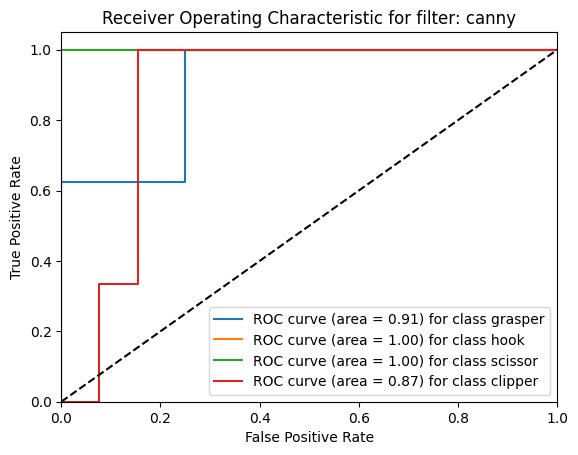

Training and evaluating model for filter: roberts
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_19 (Flatten)        (None, 9856)              0         
                                                                 
 dense_57 (Dense)            (None, 4096)              40374272  
                                                                 
 dense_58 (Dense)            (None, 2048)              8390656   
   

1/1 [==============================] - 0s 77ms/step
Precision: 0.50625
Recall: 0.5625
Accuracy: 0.5625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


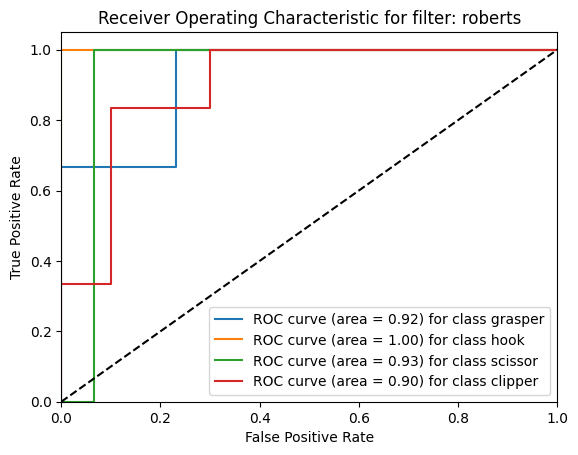

Training and evaluating model for filter: prewitt
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_20 (Flatten)        (None, 9856)              0         
                                                                 
 dense_60 (Dense)            (None, 4096)              40374272  
                                                                 
 dense_61 (Dense)            (None, 2048)              8390656   
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


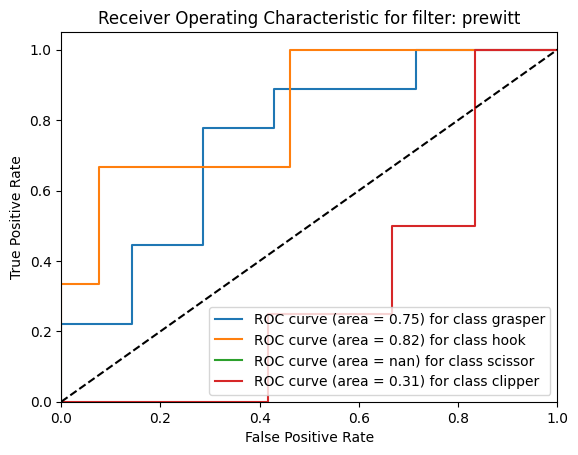

In [ ]:

    # Train the model
    history = model.fit(train_set, validation_data=validation_set, epochs=15)

    # Evaluate on the test set
    evaluation = model.evaluate(test_set)
    print(f"Test Loss: {evaluation[0]}")
    print(f"Test Accuracy: {evaluation[1]}")

    # Predicting on the test set
    test_images, test_labels = next(test_set)
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Compute Precision, Recall, and Accuracy
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    accuracy = accuracy_score(true_classes, predicted_classes)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

    # Compute ROC curve and AUC
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(NUMBER_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(NUMBER_CLASSES):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {CLASS_NAMES[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for filter: {filter_name}')
    plt.legend(loc="lower right")
    plt.show()

# Apply the filters and train/evaluate the model for each filter
filters = ['original', 'sobel', 'canny', 'roberts', 'prewitt']

for filter_name in filters:
    train_and_evaluate_model(filter_name, train_set, validation_set, test_set)

In [ ]:
# Evaluate the model
def evaluate_model(model, test_images, test_labels):
    # Evaluate on the test set
    evaluation = model.evaluate(test_images, test_labels)
    print(f"Test Loss: {evaluation[0]}")
    print(f"Test Accuracy: {evaluation[1]}")

    # Predicting on the test set
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Compute Precision, Recall, and Accuracy
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    accuracy = accuracy_score(true_classes, predicted_classes)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

    # Compute ROC curve and AUC
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(NUMBER_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return precision, recall, accuracy, roc_auc

# Store results for each filter
results = []

filters = ['original', 'sobel', 'canny', 'roberts', 'prewitt']

for filter_name in filters:
    print(f"Processing filter: {filter_name}")
    train_images, train_labels = preprocess_dataset_with_filter(train_set, filter_name)
    val_images, val_labels = preprocess_dataset_with_filter(validation_set, filter_name)
    test_images, test_labels = preprocess_dataset_with_filter(test_set, filter_name)

    model = train_model(train_images, train_labels, val_images, val_labels)
    precision, recall, accuracy, roc_auc = evaluate_model(model, test_images, test_labels)

    results.append({
        'Filter': filter_name,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    })

# Display results in a table
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)

Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.
Processing filter: original
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_21 (Flatten)        (None, 9856)              0         
                                                                 
 dense_63 (Dense)            (None, 4096)              40374272  
                                 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 82, 124, 16)       1216      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 16, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 14, 22, 32)        4640      
                                                                 
 flatten_25 (Flatten)        (None, 9856)              0         
                                                                 
 dense_75 (Dense)            (None, 4096)              40374272  
                                                                 
 dense_76 (Dense)            (None, 2048)              8390656   
                                                     